In [7]:

file_path = './dataset/dataset2.csv'

with open (file_path, 'r', encoding='latin1') as file:
    text = file.read()

###     
### carico il dataset dal file originale e faccio un processo di encoding e decoding da utf-8 per eliminare i caratteri speciali
###
text = text.replace('\x92', "'")
with open('./dataset/editato.csv', 'w', encoding='utf-8') as file2:
    file2.write(text.encode(encoding='utf-8').decode())

In [8]:
import pandas as pd

df = pd.read_csv('./dataset/editato.csv', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259569 entries, 0 to 259568
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   tweet_date_created  259569 non-null  object
 1   tweet_id            259569 non-null  int64 
 2   tweet_text          259569 non-null  object
 3   language            259569 non-null  object
 4   sentiment           259569 non-null  object
 5   sentiment_score     259569 non-null  object
dtypes: int64(1), object(5)
memory usage: 11.9+ MB


In [9]:
sentiment_counts = df['sentiment'].value_counts()

# Stampa i risultati
print("Numero di elementi con sentimento Neutral più alto:", sentiment_counts['NEUTRAL'])
print("Numero di elementi con sentimento Negative più alto:", sentiment_counts['NEGATIVE'])
print("Numero di elementi con sentimento Positive più alto:", sentiment_counts['POSITIVE'])
print("Numero di elementi con sentimento Mixed più alto:", sentiment_counts['MIXED'])

Numero di elementi con sentimento Neutral più alto: 226868
Numero di elementi con sentimento Negative più alto: 9441
Numero di elementi con sentimento Positive più alto: 22883
Numero di elementi con sentimento Mixed più alto: 377


In [10]:
import re 

def rimuovi_mentions_hashtag_e_link(testo):
    return re.sub(r'(@[\w\d]+|#[\w\d]+|https://t\.co/[\w\d]+)', '', testo)

def rimuovi_punteggiatura(testo):
    return re.sub(r'[^\w\s]', ' ', testo.lower())


df['tweet_text'] = df['tweet_text'].apply(rimuovi_mentions_hashtag_e_link)
df['tweet_text'] = df['tweet_text'].apply(rimuovi_punteggiatura)

In [ ]:
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


nlp = spacy.load("it_core_news_sm")

stop_words = set(stopwords.words('italian'))
preposizioni_articolate = [
    "al", "allo", "alla", "ai", "agli", "alla",
    "del", "dello", "della", "dei", "degli", "delle",
    "nel", "nello", "nella", "nei", "negli", "nelle",
    "sul", "sullo", "sulla", "sui", "sugli", "sulle",
    "col", "collo", "colla", "coi", "cogli", "colle",
    "dal", "dallo", "dalla", "dai", "dagli", "dalle",
    "nel", "nello", "nella", "nei", "negli", "nelle",
    "pel", "pello", "pella", "pei", "pegli", "pelle",
    "sul", "sullo", "sulla", "sui", "sugli", "sulle",
    "con","d","c","l"
]
stop_words.update(preposizioni_articolate)

def tokenizza_testo(testo):
    return word_tokenize(testo)

def lemmatizza_testo(parole_tokenizzate):
    parole_lemmatizzate = []
    for token in nlp(" ".join(parole_tokenizzate)):
        if token.lemma_.lower() not in stop_words:
            parole_lemmatizzate.append(token.lemma_)
    return parole_lemmatizzate

def rimuovi_stop_words(parole):
    return [parola for parola in parole if parola.lower() not in stop_words]



def processa_testo(testo):
    parole_tokenizzate = tokenizza_testo(testo)
    parole_pulite = rimuovi_stop_words(parole_tokenizzate)
    parole_lemmatizzate = lemmatizza_testo(parole_pulite)
    return parole_lemmatizzate


df['processed_text'] = df['tweet_text'].apply(processa_testo)

In [ ]:
#salvataggio del dataset ottenuto dalla fase di preprocessing in un file csv
df.to_csv('./dataset/processed.csv', index=False)

In [ ]:
df = pd.read_csv('processed.csv')

df = df[['processed_text', 'sentiment']]

df['processed_text'] = df['processed_text'].apply(lambda x: x.replace('[','').replace(']','').replace(',','').replace("'",''))

df.to_csv('./dataset/testo_e_sentiment.csv', index=False)

In [ ]:
import pandas as pd

df = pd.read_csv('testo_e_sentiment.csv')
num_negative = (df['sentiment'] == 'NEGATIVE').sum()

undersampled_df = pd.concat([
    df[df['sentiment'] == 'NEGATIVE'],  
    df[df['sentiment'] == 'POSITIVE'].sample(n=num_negative, random_state=42),  
    df[df['sentiment'] == 'NEUTRAL'].sample(n=num_negative, random_state=42) 
])

undersampled_df = undersampled_df.sample(frac=1, random_state=42)

print(undersampled_df['sentiment'].value_counts())

undersampled_df.to_csv('./dataset/undersampled.csv', index=False)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import numpy as np
import pandas as pd
import scipy

df = pd.read_csv('./dataset/undersampled.csv')

num_batches = 27

batch_size = len(df) // num_batches

vectorizer = CountVectorizer()

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))
    batch_data = df['processed_text'].astype('U').values[start_idx:end_idx]
    vectorizer.fit(batch_data)

X_bow = None

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))
    batch_data = df['processed_text'].astype('U').values[start_idx:end_idx]
    X_batch = vectorizer.transform(batch_data)
    if X_bow is None:
        X_bow = X_batch
    else:
        X_bow = scipy.sparse.vstack([X_bow, X_batch])

#export vectorizer with joblib
joblib.dump(vectorizer, './vectorizer.joblib')

['./vectorizer.joblib']

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(
                                    X_bow, df['sentiment'],
                                    test_size=0.2,
                                    random_state=42
                                    )

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



Accuracy: 0.7645189761694616


In [ ]:
import joblib

joblib.dump(svm_model, 'svm_model.joblib')


['svm_model.joblib']

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\giova\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\giova\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Connessione in corso interrotta forzatamente dall'host remoto
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\giova\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\giova\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_se

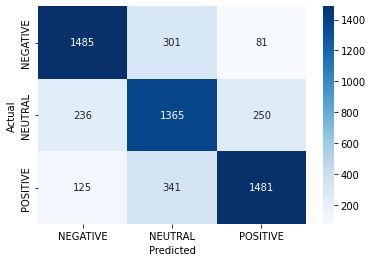

In [8]:
#matrice di confusione 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

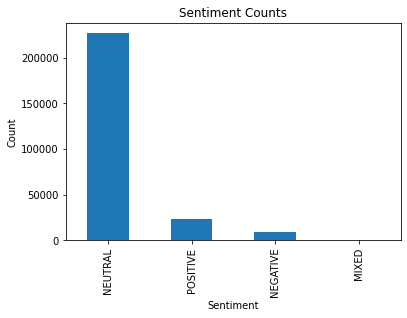

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./dataset/dataset2.csv', encoding='latin1')

#grafico che mostra la class imbalance della colonna sentiment

sentiment_counts = df['sentiment'].value_counts()

sentiment_counts.plot(kind='bar')
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.show()

In [4]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7682496084798859
Recall: 0.7645189761694616
